<div style="text-align:center">    
     <h1 align="center">Day 14 of #66daysofdata_NLP</h1>  
</div>


***
## Topic Modeling Task 
### Kaggle Steam Review Dataset
#### `RegEx` & `SymSpell`


***
* Ref: 
    - [https://blog.insightdatascience.com](https://blog.insightdatascience.com/contextual-topic-identification-4291d256a032)
    
* data set:
    - [steam-reviews-dataset](https://www.kaggle.com/luthfim/steam-reviews-dataset) 
    - Context:
        * Steam Review Datasets, published on Kaggle as a .csv file. It covers __`380,000 video game reviews`__ from `46 best selling games` on Steam. 
        * The raw text data needed to be carefully pre-processed before we could feed it into a model, so we can used `RegEx` to filter certain patterns for \n\nNormalization and `SymSpell` for typo correction.


***
<h3 align="center">Topic Modeling Task</h3>   
<div style="text-align:center">    
    <img  src="../images/Topic_modeling.png" />
    <a href="https://miro.medium.com/max/2000/1*Cdp4y1tfMxqoj96o6lUdFg.png">img ref</a> 
</div>

- `Exploratory data analysis (EDA)` is used to get insights about how the data is `distributed and structured`

***
#### Methods

* Typically, there are two ways to complete the `topic identification task`. 
    
    - We can either resort to hierarchical Bayesian models, like `latent Dirichlet allocation (LDA)`, or 
    - we can embed our target documents into some `vector space` and identify their `similarity structure` in the vector space by `clustering` methods.
***

In [1]:
'''
!pip install language-detector
!pip install stop-words
!pip install symspellpy # Spelling correction & Fuzzy search: 1 million times faster through Symmetric Delete spelling correction algorithm
!pip install umap       # UMAP is a general purpose manifold learning and dimension reduction algorithm.
!pip install umap-learn
!pip install pyLDAvis
!pip install -U sentence-transformers #Sentence Embeddings using BERT / RoBERTa / DistilBERT / ALBERT / XLNet with PyTorch

!pip install tbb-devel
!pip install --upgrade --force-reinstall numba==0.53.1
'''

'\n!pip install language-detector\n!pip install stop-words\n!pip install symspellpy # Spelling correction & Fuzzy search: 1 million times faster through Symmetric Delete spelling correction algorithm\n!pip install umap       # UMAP is a general purpose manifold learning and dimension reduction algorithm.\n!pip install umap-learn\n!pip install pyLDAvis\n!pip install -U sentence-transformers #Sentence Embeddings using BERT / RoBERTa / DistilBERT / ALBERT / XLNet with PyTorch\n\n!pip install tbb-devel\n!pip install --upgrade --force-reinstall numba==0.53.1\n'

## Loading libraries


In [2]:
import os
import pandas as pd
import numpy as np
import gensim
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
import string
import umap.umap_ as umap
from collections import Counter
import matplotlib.pyplot as plt

import nltk
from language_detector import detect_language
from stop_words import get_stop_words
from gensim.models.coherencemodel import CoherenceModel

import pkg_resources
from symspellpy import SymSpell, Verbosity
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from sklearn.cluster import KMeans
from datetime import datetime
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

### Preparing the dictionary for `typo correction` purpose

In [3]:
sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

###  Loading the `steam_reviews` data set

In [4]:
data = pd.read_csv('../datasets/steam_reviews.csv')
data = data.fillna('')  # only the comments has NaN's
rws = data.review
display(data.head())

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


In [5]:
print (f'Sample review:\n {rws[2]} \n')
print(f'Number of reviews: {len(rws)}\n')


Sample review:
 Very good game although a bit overpriced in my opinion. I'd prefer playing the game with mods (historical accuracy so on) although the vanilla version is good aswell. 7/10 

Number of reviews: 434891



## Prteprocessing

### Step 1: sentence level preprocess

In [6]:
###################################
#### sentence level preprocess ####
###################################
# filtering out stop words
# create English stop words list
en_stop = get_stop_words('en')
en_stop.append('game')
en_stop.append('play')
en_stop.append('player')
en_stop.append('time')


def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in en_stop]

# lowercase + base filter
# some basic Normalization
def f_base(s,stops, verbose = 0 ):
    """
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    print(f'Original review\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s);          print(f'\n\nNormalization 1: xxxThis is a --> xxx. This is a (missing delimiter)\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 2: lower case
    s = s.lower();                                         print(f'\n\nNormalization 2: lower case\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s);                        print(f'\n\nNormalization 3: "&gt" or ">", "&lt" or "<"\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s);                print(f'\n\nNormalization 4: letter repetition (if more than 2)\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s);                print(f'\n\nNormalization 5: non-word repetition (if more than 1)\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s);                  print(f'\n\nNormalization 6: string * as delimiter\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s);                       print(f'\n\nNormalization 7: stuff in parenthesis, assumed to be less informal\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s);                         print(f'\n\nNormalization 8: xxx[?!]. -- > xxx.\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s);             print(f'\n\nNormalization 9: [.?!] --> [.?!] xxx\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s);                          print(f"\n\nNormalization 10: ' ing ', noise text\n\n{s}") if verbose == 1 else False
    # \n\nNormalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s); print(f'\n\nNormalization 11: noise text\n\n{s}') if verbose == 1 else False
    # \n\nNormalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s);               print(f'\n\nNormalization 12: phrase repetition\n\n{s}') if verbose == 1 else False
    
    '''# removes all punctuation
    s = s.translate(str.maketrans("", "", string.punctuation)); print(f'\n\nNormalization 13: remove punctuations\n\n{s}') if verbose == 1 else False
    
    #removes all stop words, including months
    words = s.split()
    s = []
    s = f_stopw(words)    
            
    #reassembles the text without stop words
    # or -- > list to sentence
    s = " ".join(s) 
    
    #removes all numbers
    s = "".join([i for i in s if not i.isdigit()]);        print(f'\n\nNormalization 14: remove stop words and digits\n\n{s}') if verbose == 1 else False   
    '''
    # \n\nNormalization 13: strip
    s = s.strip();                                         print(f'\n\nNormalization 15: strip\n\n{s}') if verbose == 1 else False   
    
    return s

# language detection
def f_lan(s):
    """
    :param s: string to be processed
    :return: boolean (s is English)
    """
    # some reviews are actually english but biased toward french
    return detect_language(s) in {'English', 'French'}

def preprocess_sent(rw, verbose = 0):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw, en_stop, verbose)
    if not f_lan(s):
        return None
    return s

### Step 2: Word level preprocessing

In [7]:
###############################
#### word level preprocess ####
###############################

# filtering out punctuations and numbers
def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha()]


# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']


# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
            # do word segmentation, deprecated for inefficiency
            # w_seg = sym_spell.word_segmentation(phrase=word)
            # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed


# stemming if doing word-wise
p_stemmer = PorterStemmer()


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) for word in w_list]


# filtering out stop words
# create English stop words list
en_stop = get_stop_words('en')
en_stop.append('game')
en_stop.append('play')
en_stop.append('player')
en_stop.append('time')


def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in en_stop]


def preprocess_word(s, verbose = 0):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    print(f'Steps of word preprocessing\n\nStep 1: word_tokenize\n\n{w_list}') if verbose == 1 else False
    w_list = f_punct(w_list); print(f'\n\nStep 2: filtering out punctuations and numbers\n{w_list}') if verbose == 1 else False
    w_list = f_noun(w_list);  print(f'\n\nStep 3: selecting nouns\n{w_list}') if verbose == 1 else False
    w_list = f_typo(w_list);  print(f'\n\nStep 4: typo correction\n{w_list}') if verbose == 1 else False
    w_list = f_stem(w_list);  print(f'\n\nStep 5: w_list with stemming\n{w_list}') if verbose == 1 else False
    w_list = f_stopw(w_list); print(f'\n\nStep 6: filtering out stop words\n{w_list}') if verbose == 1 else False

    return w_list

#### Let's applying preprocessing on a sample review to see whats going on under the hood

In [63]:
samp = np.random.choice(len(rws), 1)
s = rws[samp[0]]
print(f'Sample --> {samp[0]}\n\nOriginal review is :\n{s}\n----------------------------------------------')
sentence = preprocess_sent(s,verbose =0)
print(f"preprocess_sent: \n\n{sentence}\n----------------------------------------------")

token_list = preprocess_word(sentence, verbose=1)
print(f"\n\nFinal Token list is:\n{token_list}")

Sample --> 92496

Original review is :
This game is extremly fun all the time and can get very intense. Even more enjoyable with friends.
----------------------------------------------
preprocess_sent: 

this game is extremly fun all the time and can get very intense. even more enjoyable with friends.
----------------------------------------------
Steps of word preprocessing

Step 1: word_tokenize

['this', 'game', 'is', 'extremly', 'fun', 'all', 'the', 'time', 'and', 'can', 'get', 'very', 'intense', '.', 'even', 'more', 'enjoyable', 'with', 'friends', '.']


Step 2: filtering out punctuations and numbers
['this', 'game', 'is', 'extremly', 'fun', 'all', 'the', 'time', 'and', 'can', 'get', 'very', 'intense', 'even', 'more', 'enjoyable', 'with', 'friends']


Step 3: selecting nouns
['game', 'time', 'friends']


Step 4: typo correction
['game', 'time', 'friends']


Step 5: w_list with stemming
['game', 'time', 'friend']


Step 6: filtering out stop words
['friend']


Final Token list is:


#### Applying preprocessing on `10,000 random review` samples

In [9]:
samp_size = 10000


def preprocess(docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    #     samp = list(range(100))
    samp = np.random.choice(n_docs, samp_size)
    
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    print(f"\nFrom {samp_size} sample reviews, {len(sentences)} samples were accepted!\n")
    return sentences, token_lists, idx_in

sentences, token_lists, idx_in = preprocess(rws, samp_size=samp_size)

Preprocessing raw texts ...
Preprocessing raw texts. Done!

From 10000 sample reviews, 7837 samples were accepted!



In [61]:
sam = 10
print( f'{idx_in[sam]}-th sample sentence: \n\n"{sentences[sam][0:90]} ..."\n\n\nAnd its token words list:\n\n{token_lists[sam]} ')

234697-th sample sentence: 

"i have to say i think i'm done with this game and it's frankly shameful that it took this  ..."


And its token words list:

['summari', 'peopl', 'bullet', 'shot', 'head', 'bodi', 'peopl', 'shot', 'map', 'emphasi', 'rang', 'peopl', 'person', 'screen', 'damag', 'hour', 'packet', 'packet', 'ping', 'stealth', 'hunt', 'part', 'peopl', 'footstep', 'sound', 'effect', 'mean', 'team', 'build', 'zero', 'sound', 'speak', 'team', 'squad', 'number', 'peopl', 'anoth', 'loot', 'noth', 'fluke', 'minut', 'pointless', 'rang', 'fight', 'peopl', 'threat', 'way', 'peopl', 'team', 'nois', 'scenario', 'point', 'chin', 'fist', 'wait', 'bar', 'signal', 'enemi', 'exchang', 'someth', 'line', 'yellow', 'come', 'peopl', 'move', 'rock', 'tree', 'field', 'fight', 'cover', 'rest', 'team', 'die', 'peopl', 'mistak', 'anoth', 'mistak', 'amateur', 'engin', 'mod', 'hour', 'hour', 'way', 'cartoon', 'popcorn', 'forehead'] 


***
<div style="text-align:center">    
     <h1 align="center">Day 15 of #66daysofdata_NLP</h1>  
</div>

* turn `tokenized` documents into a `id <-> term dictionary`

In [11]:
dictionary = corpora.Dictionary(token_lists)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in token_lists]

In [12]:
print(dictionary,'\n\nTokenized list:',token_lists[:2],'\ncorpus        :',corpus[:2])

Dictionary(5280 unique tokens: ['ball', 'pan', 'steel', 'job', 'laugh']...) 

Tokenized list: [['steel', 'pan', 'ball'], ['job']] 
corpus        : [[(0, 1), (1, 1), (2, 1)], [(3, 1)]]


***
## TF-IDF topic modeling

In [13]:


print('Getting vector representations for TF-IDF ...')
tfidf = TfidfVectorizer(
    lowercase=True,        # allows us to lowercase our data.
    max_features=100,      # this is how many words out of the entire corpus we want to take into account. 
    max_df=0.8,            # this is a float that tells the algorithm to ignore any word that occurs in 80% of the documents. 
    min_df=5,              # this is an integer that tells the algorithm to ignore words that do not occur more than 5 times in the entire corpus.
    ngram_range = (1,3),   # this is a tuple with index 0 being the smallest number of words to consider with the second index being the largest, 
                           # i.e. 2 for bigram and 3 for trigrams. (1, 3) means the algorithm should consider anything from a unigram (one word)
                           # to trigram (three words) as a concept.
    stop_words = "english" # this is the language you are working with and you are telling the algorithm to ignore the predefined set of stopwords.
)

vec_tfid = tfidf.fit_transform(sentences)
feature_names = tfidf.get_feature_names()
print('Getting vector representations for TF-IDF. Done!')

Getting vector representations for TF-IDF ...
Getting vector representations for TF-IDF. Done!


In [14]:
print(f"""Length of `sentences`:        --> '{len(sentences)}' \nvectors shape:                --> {vec_tfid.shape}              
Number of feature_nemes:      --> '{len(feature_names)}' \n
     """)

Length of `sentences`:        --> '7837' 
vectors shape:                --> (7837, 100)              
Number of feature_nemes:      --> '100' 

     


In [15]:
def vec_2_feature_names(vector):
    # convert to dataframe
    df = pd.DataFrame(vector.toarray())
    # indies of non zero columns (in 100 columns)
    inds =  df.columns[(df != 0).any()]
    # find feature names of non zero columns
    FN = []
    for ind in inds:
        FN.append(feature_names[ind])
    return FN

print(f"Sample doc: \n{sentences[1]}\n")        
feature_nemes = vec_2_feature_names(vec_tfid[1])
print(f"Its feature names: \n{feature_nemes}\n")

print (f"Its vectororize version with TF-IDF score:\n{vec_tfid[1]}")

Sample doc: 
they did a pretty good job so far.

Its feature names: 
['did', 'good', 'pretty']

Its vectororize version with TF-IDF score:
  (0, 34)	0.4244662443522711
  (0, 73)	0.6128333266544862
  (0, 18)	0.6665311104120152


### K-Means Clusterin

* K-Means seeks to place every document into a cluster to which it has the most similarity.

In [16]:
# number of topics
true_k = 10

cluster_model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)


In [17]:
cluster_model.fit(vec_tfid)
print('Clustering embeddings. Done!')
order_centroids = cluster_model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
print(f"Length of `terms`:       --> '{len(terms)}' \norder_centroids shape:   --> {order_centroids.shape}' \n")
print (f"Sample feature name:'    --> '{terms[order_centroids[0][0]]}''")

Clustering embeddings. Done!
Length of `terms`:       --> '100' 
order_centroids shape:   --> (10, 100)' 

Sample feature name:'    --> '10''


### We have clusterd ~ 75000 sample reviews into 10 topics. 


In [18]:
#  list to just the first 10 words for each clusters
def cluster2dataframe(order_centroids, terms):
    clusters_dict = {}
    header = []
    for i, cluster in enumerate(order_centroids):
        col_name = f"Cluster {i}"
        header.append(col_name)
        cluster_terms = []
        for keyword in cluster:
            cluster_terms.append(terms[keyword])
        clusters_dict[col_name] = cluster_terms

    df_clusters = pd.DataFrame.from_dict(clusters_dict)
    return df_clusters
df_clusters = cluster2dataframe(order_centroids,terms)
df_clusters.head(10)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
0,10,servers,online,worth,game,hours,game,best,fix,fun
1,10 10,game,gta,game,like,game,play,game,game,game
2,good,fix,game,money,time,play,like,played,issues,fun game
3,mods,play,rockstar,fun,recommend,played,just,games,server,friends
4,got,fun,player,time,great,fun,good,friends,play,play
5,love,just,money,great,play,playing,great,ve,time,really
6,better,good,modding,play,really,10,time,fun,getting,great
7,game,server,single,good,update,ve,people,multiplayer,pubg,good
8,awesome,bugs,story,really,awesome,time,buy,10,multiplayer,lot
9,modding,time,buy,fun game,friends,like,really,recommend,hackers,playing


### Visualize the clustering results

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    plt.rcParams["figure.figsize"] = (20,10)
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], 'o', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)
    
def visualize(vec, model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    #pca = PCA(n_components=2)
    #scatter_plot_points = pca.fit_transform(vec.toarray())
    
    tsne = TSNE(n_components=2, perplexity=10,  init='pca')#n_iter=300,
    try:
        scatter_plot_points = tsne.fit_transform(vec.toarray())
    except:
        scatter_plot_points = tsne.fit_transform(vec)
    '''   
   
    reducer = umap.UMAP()
    #print('Calculating UMAP projection ...')
    scatter_plot_points = reducer.fit_transform(vec)
    '''
    #print('Calculating UMAP projection. Done!')
    plot_proj(scatter_plot_points, model.labels_)

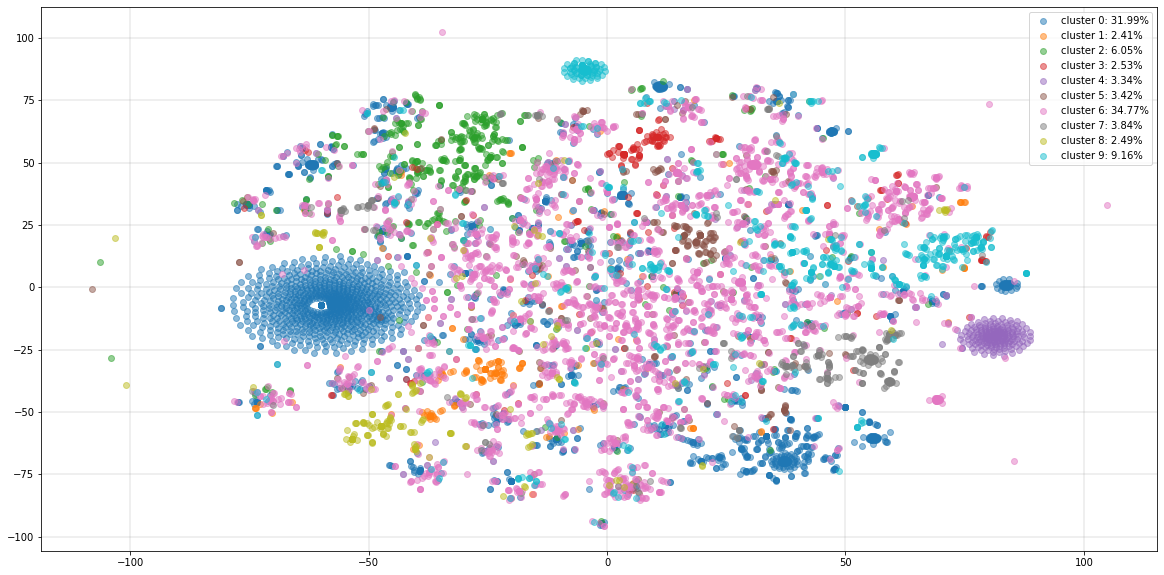

In [20]:
visualize(vec_tfid, cluster_model)

In [21]:
def get_topic_words(token_lists, labels, k=None):
    """
    return topics: list with top N words per topic
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))

    return topics

topics = get_topic_words(token_lists, cluster_model.labels_)

* `Topic Coherence` is a useful metric for `measuring the human interpretability` of a given `LDA topic model` or `topics`.

In [22]:
cm = CoherenceModel(topics=topics, texts=token_lists, corpus=corpus, dictionary=dictionary,  coherence='c_v')
print('Model Coherence score:', cm.get_coherence(),'\n')

Model Coherence score: 0.5371791549955872 



* Compute the mean Silhouette Coefficient of all samples.
        The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [23]:
from sklearn.metrics import silhouette_score
lbs = cluster_model.labels_
print(f'silhouette_score is: {silhouette_score(vec_tfid, lbs)}')

silhouette_score is: 0.06586311216753876


For TF-IDF, `the result was not good`, in the sense that we can neither get separated nor balanced clusters. Because `TF-IDF is also bag-of-words based` (disregarding grammar and word order), it `loses contextual information` and `suffers from` the data being `incoherent and unstructured`.




***
<div style="text-align:center">    
     <h1 align="center">Day 16 of #66daysofdata_NLP</h1>  
</div>

<h3 align="center">LDA (Latent Dirichlet Allocation)</h3>   


LDA (Latent Dirichlet Allocation) is a `generative statistical` `unsupervised machine-learning` model that takes `documents as input` and `finds topics as output`. 

- The model also says in `what percentage each document talks about each topic`.

* A __`topic`__ is represented as a `weighted list of words`. 


        Science (topic): Galaxy * 0,4 | Planet * 0,4 | Ball * 0,1  | Referendum * 0.1


<div align="center"> 
    <img  src="../images/LDA_formula.png" />
</div>   
<div align="center"> 
    <img  src="../images/LDA.png" />
    
    <a href="https://www.youtube.com/watch?v=T05t-SqKArY">ref_1</a> 
    <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation">ref_2</a>
    <a href="https://www.kdnuggets.com/2019/09/overview-topics-extraction-python-latent-dirichlet-allocation.html">ref_3</a>
    
</div>

In [24]:
print('Getting vector representations for LDA ...')
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=true_k, id2word=dictionary, passes=20)
print('Fitting LDA Done!\n')
print(ldamodel)

Getting vector representations for LDA ...
Fitting LDA Done!

LdaModel(num_terms=5280, num_topics=10, decay=0.5, chunksize=2000)


In [25]:
sample_corpus = corpus[9]
tokens = token_lists[9]
print(f'\nSample_corpus:\n{sample_corpus}\n{tokens}\n\nAnd its LDA.get_document_topics:')
for topic,prob in ldamodel.get_document_topics(sample_corpus):
    print(f"Topic: {topic} probability: --> {prob:.2f}")


Sample_corpus:
[(45, 1), (46, 1)]
['mod', 'costar']

And its LDA.get_document_topics:
Topic: 0 probability: --> 0.03
Topic: 1 probability: --> 0.36
Topic: 2 probability: --> 0.03
Topic: 3 probability: --> 0.03
Topic: 4 probability: --> 0.03
Topic: 5 probability: --> 0.03
Topic: 6 probability: --> 0.03
Topic: 7 probability: --> 0.03
Topic: 8 probability: --> 0.03
Topic: 9 probability: --> 0.37


In [26]:
cm = CoherenceModel(model=ldamodel, texts=token_lists, corpus=corpus, dictionary=dictionary,
                            coherence='c_v')

* `Topic Coherence` is a useful metric for `measuring the human interpretability` of a given `LDA topic model` or `topics`.

In [27]:
print('Model Coherence score:', cm.get_coherence())

Model Coherence score: 0.5342526533247719


### Vizualizing the Data

In [28]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.088095 -0.015424       1        1  17.120328
9      0.087626  0.005867       2        1  16.152275
7      0.166010 -0.127916       3        1  12.546770
2     -0.029094  0.107692       4        1  10.018502
5      0.082707  0.198573       5        1  10.000859
1      0.074609  0.092787       6        1   8.970485
0     -0.074340  0.069214       7        1   7.383827
4      0.083265 -0.254011       8        1   6.755786
3     -0.298613 -0.121011       9        1   5.540314
6     -0.180264  0.044229      10        1   5.510854, topic_info=       Term         Freq        Total Category  logprob  loglift
41      fun  1044.000000  1044.000000  Default  30.0000  30.0000
25   friend   991.000000   991.000000  Default  29.0000  29.0000
173  server   692.000000   692.000000  Default  28.0000  28.0000
235  hacker   438.000000   438.000000  Default  27.0000  27.0000
146   money   750.000000   750.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
443     bug    39.556104   445.547970  Topic10  -4.5832   0.4769
141   video    23.771061    77.104756  Topic10  -5.0925   1.7218
551    rust    31.087232   273.603140  Topic10  -4.8241   0.7236
335  someon    26.982823   215.448960  Topic10  -4.9657   0.8209
77   number    20.204708    68.097385  Topic10  -5.2550   1.6834

[639 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
164       1  0.968462     access
164       8  0.027009     access
429       2  0.411653    account
429       7  0.581157    account
194       2  0.932554      activ
...     ...       ...        ...
183       6  0.016134       year
183      10  0.390433       year
869      10  0.952072  yesterday
104       9  0.983900       zero
954       1  0.982567       zone

[1133 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 8, 3, 6, 2, 1, 5, 4, 7])

### TF-IDF REMOVAL

In [29]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel


tfidf = TfidfModel(corpus, id2word=dictionary)

low_value = 0.03
def tfidf_removal(tfidf, corpus, low_value):
    words  = []
    words_missing_in_tfidf = []
    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = [] #reinitialize to be safe. You can skip this.
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        for item in drops:
            words.append(dictionary[item])
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        corpus[i] = new_bow
    return corpus

corpus_new = tfidf_removal(tfidf, corpus, low_value, )

In [30]:
ldamodel_new = gensim.models.ldamodel.LdaModel(corpus=corpus_new,
                                           id2word=dictionary,
                                           num_topics=true_k,
                                           passes=20
                                          )

In [31]:
cm = CoherenceModel(model=ldamodel_new, texts=token_lists, corpus=corpus_new, dictionary=dictionary, coherence='c_v')
print('Model Coherence score:', cm.get_coherence())

Model Coherence score: 0.558046348385963


In [32]:
pyLDAvis.gensim.prepare(ldamodel_new, corpus_new, dictionary, mds="mmds", R=30)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.215785  0.247182       1        1  16.448034
6      0.011634  0.250687       2        1  16.424098
8     -0.278600  0.104816       3        1  14.450117
1     -0.136185  0.351017       4        1  11.782764
5      0.050742 -0.184617       5        1  10.289198
7     -0.057449  0.027221       6        1   9.313349
4     -0.115931 -0.361483       7        1   6.111778
3     -0.355197 -0.172775       8        1   5.215829
2      0.266811 -0.246312       9        1   5.066289
9      0.398390 -0.015737      10        1   4.898542, topic_info=       Term         Freq        Total Category  logprob  loglift
25   friend   996.000000   996.000000  Default  30.0000  30.0000
41      fun  1043.000000  1043.000000  Default  29.0000  29.0000
204     car   383.000000   383.000000  Default  28.0000  28.0000
146   money   747.000000   747.000000  Default  27.0000  27.0000
46      mod   420.000000   420.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
76     noth    53.592142   270.807127  Topic10  -4.1584   1.3962
118   stuff    40.750775   193.029188  Topic10  -4.4323   1.4609
691   crate    31.885576   109.068298  Topic10  -4.6776   1.7864
50     bodi    16.995628    36.032584  Topic10  -5.3068   2.2648
316   thank    19.711182    91.065905  Topic10  -5.1586   1.4858

[640 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1230      4  0.855588    abbot
1476      6  0.903542  absolut
164       2  0.099459   access
164       3  0.051719   access
164       4  0.739977   access
...     ...       ...      ...
468       8  0.092564   youtub
468      10  0.647946   youtub
104       6  0.948459     zero
954       5  0.890747     zone
954       9  0.083508     zone

[1151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 9, 2, 6, 8, 5, 4, 3, 10])

***
<div style="text-align:center">    
     <h1 align="center">Day 17 of #66daysofdata_NLP</h1>  
</div>


<h3 align="center">BERT sentence embedding
</h3>   


`sentence embedding models (BERT)` is used to `embed reviews into a vector space` where the vectors capture the `contextual meaning` of sentences. As can be seen in the visualization below, the result was OK, but still difficult to identify the clustering if we remove the colors.


    
<div style="text-align:center"> 
    <img  src="../images/Bert.png" />
    
    <a href="https://revuze.it/blog/bert-nlp/">ref_1</a> 
    
    
   
</div>



## Bert: encode sentences --> vectors

In [35]:
print('Getting vector representations for BERT ...')
from sentence_transformers import SentenceTransformer
model_bert = SentenceTransformer('bert-base-nli-max-tokens')

# encode sentences --> vectors
vec_bert = np.array(model_bert.encode(sentences, show_progress_bar=True))
print('Getting vector representations for BERT. Done!')

Getting vector representations for BERT ...


/home/pi/anaconda3/envs/p36/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Batches:   0%|          | 0/245 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!


In [36]:
# number of topics
true_k = 10

cluster_model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)
cluster_model.fit(vec_bert)
print('Clustering embeddings. Done!')

Clustering embeddings. Done!


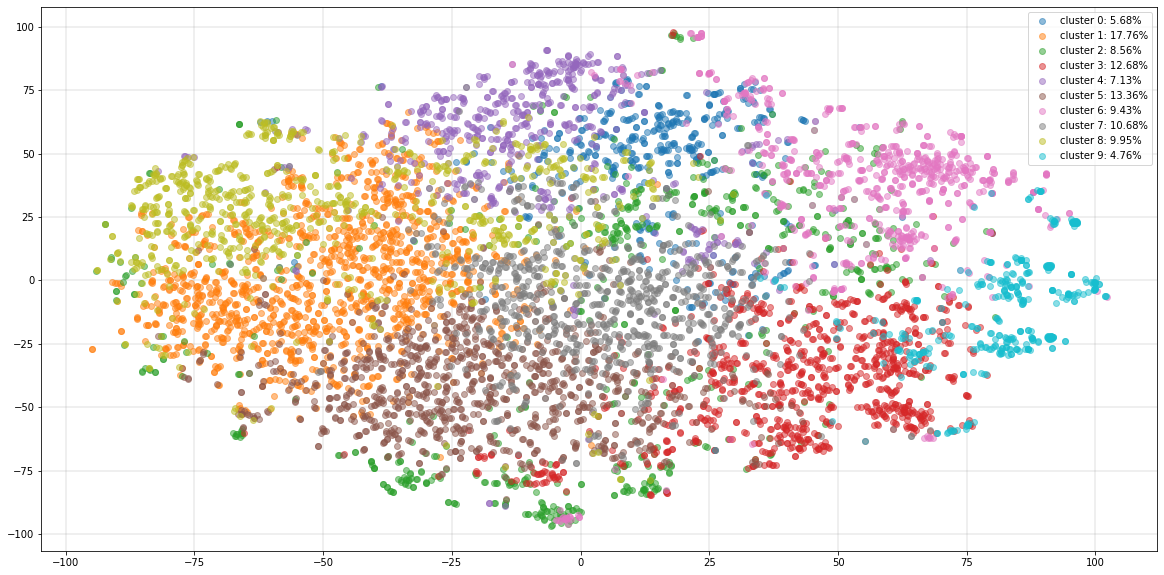

In [37]:
visualize(vec_bert, cluster_model)

In [38]:
topics = get_topic_words(token_lists, cluster_model.labels_)
cm = CoherenceModel(topics=topics, texts=token_lists, corpus=corpus, dictionary=dictionary,  coherence='c_v')
print('Model Coherence score:', cm.get_coherence(),'\n')

Model Coherence score: 0.5059863884092805 



In [39]:

lbs = cluster_model.labels_
print(f'silhouette score is: {silhouette_score(vec_bert, lbs)}')

silhouette score is: 0.05919571593403816


***
<div style="text-align:center">    
     <h1 align="center">Day 18 of #66daysofdata_NLP</h1>  
</div>


<h3 align="center">BERT + LDA + Auto-encoder</h3>   




    
<div style="text-align:center"> 
    <img  src="../images/bert-lda.png" />
    
    <a href="https://miro.medium.com/max/2000/1*OKCYnB-JbGq1NDwNSKd5Zw.png">ref_1</a>   
   
</div>

- The combined vectors(t) are passed into a deep learning auto-encoder latent vector space 
    to ensure `dimensionality reduction` and `noise removal` to arrive at the best topic clusters.

In [40]:
def get_vec_lda(model, corpus, k):
    """
    Get the LDA vector representation (probabilistic topic assignments for all documents)
    :return: vec_lda with dimension: (n_doc * n_topic)
    """
    n_doc = len(corpus)
    vec_lda = np.zeros((n_doc, k))
    for i in range(n_doc):
        # get the distribution for the i-th document in corpus
        for topic, prob in model.get_document_topics(corpus[i]):
            vec_lda[i, topic] = prob

    return vec_lda            


## convert corpus --> vector using LDA_Model

In [41]:
vec_lda =  get_vec_lda(ldamodel, corpus, true_k)

print(f'LDA vector shape is:  {vec_lda.shape}')

LDA vector shape is:  (7837, 10)


In [42]:
print(f'Bert vector shape is:  {vec_bert.shape}')
   

Bert vector shape is:  (7837, 768)


#### Combining **LDA_vector** and **BERT_Vector**

In [43]:
gamma = 15
vec_ldabert = np.c_[vec_lda * gamma, vec_bert]
print(f'LDA_Bert vector shape is:  {vec_ldabert.shape}')


LDA_Bert vector shape is:  (7837, 778)


Clustering embeddings. Done!


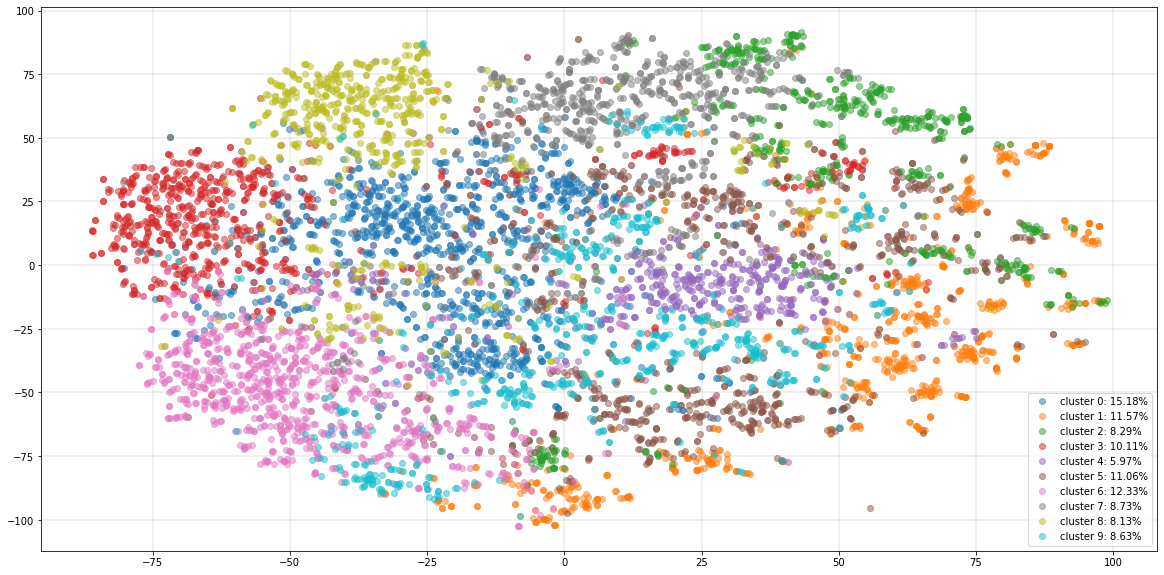

In [50]:
cluster_model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

cluster_model.fit(vec_ldabert)
print('Clustering embeddings. Done!')
visualize(vec_ldabert, cluster_model)

In [51]:
lbs = cluster_model.labels_
topics = get_topic_words(token_lists, lbs)
cm = CoherenceModel(topics=topics, texts=token_lists, corpus=corpus, dictionary=dictionary,  coherence='c_v')
print('Model Coherence score:', cm.get_coherence(),'\n')

print(f'silhouette_score is: {silhouette_score(vec_ldabert, lbs)}')

Model Coherence score: 0.5533187045097085 

silhouette_score is: 0.08100343811364266


***
<div style="text-align:center">    
     <h1 align="center">Day 19 of #66daysofdata_NLP</h1>  
</div>

## __Autoencoder__ as for dimension reduction

In [45]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

In [47]:
AE = Autoencoder()
print('Fitting Autoencoder ...')
AE.fit(vec_ldabert)
print('Fitting Autoencoder Done!')
vec_ldabert_ae = AE.encoder.predict(vec_ldabert)
print(f'\nDimension reduction from {vec_ldabert.shape} to :  {vec_ldabert_ae.shape}')


Fitting Autoencoder ...
Fitting Autoencoder Done!

Dimension reduction from (7837, 778) to :  (7837, 32)


Clustering embeddings. Done!


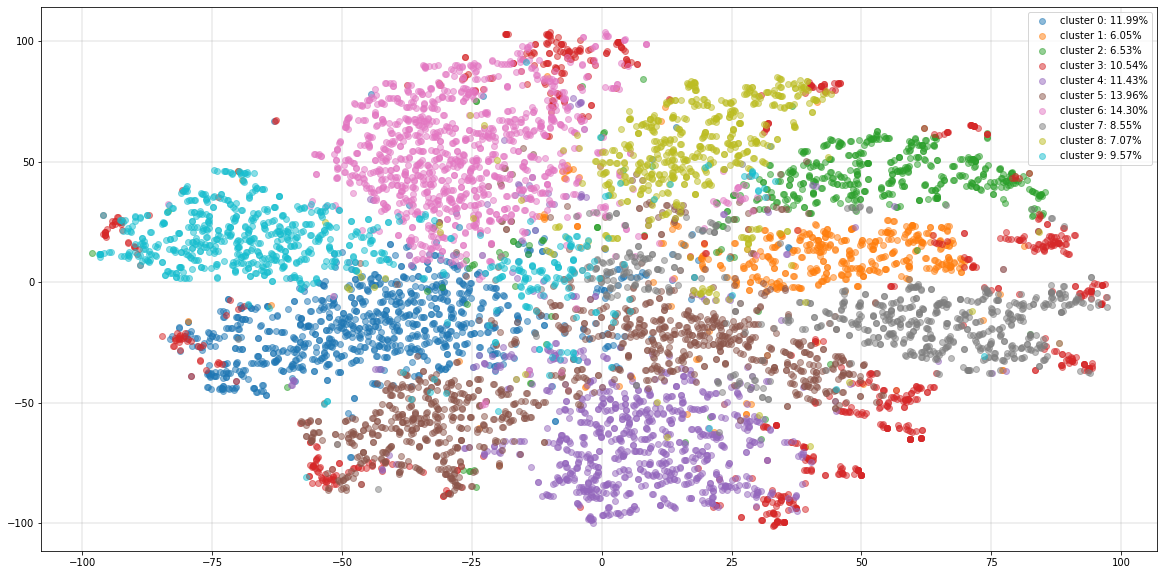

In [48]:
cluster_model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

cluster_model.fit(vec_ldabert_ae)
print('Clustering embeddings. Done!')
visualize(vec_ldabert_ae, cluster_model)

In [49]:
lbs = cluster_model.labels_
topics = get_topic_words(token_lists, lbs)
cm = CoherenceModel(topics=topics, texts=token_lists, corpus=corpus, dictionary=dictionary,  coherence='c_v')
print('Model Coherence score:', cm.get_coherence(),'\n')

print(f'silhouette_score is: {silhouette_score(vec_ldabert_ae, lbs)}')

Model Coherence score: 0.5535734053592567 

silhouette_score is: 0.13969990611076355


| | TFIDF  | Bert | LDA-Bert  | Bert-LDA-AutoEencoder |
|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|
| |<img  src="../images/14-19_clus1_tfidf.png" width="300"/>  | <img  src="../images/14-19_clus2_bert.png" width="300"/>  | <img  src="../images/14-19_clus3_lda.png" width="300"/> | <img  src="../images/14-19_clus4_bert_AEn.png" width="300"/> |
|__Model Coherence score__ |   0.537|  0.505|   0.553|   0.553|
|__silhouette_score__ | 0.065  | 0.059  | 0.081 | 0.139 |